In [1]:
import numpy as np
import pandas as pd 


from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()
data_shift

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [3]:
p_train = 0.8

train_set = data_shift.iloc[:int(143*0.8)]
valid_set = data_shift.iloc[int(143*0.8):]

In [4]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

n_steps = 12
train_x,train_y = split_sequence(np.array(train_set['#Passengers']),n_steps)
valid_x,valid_y = split_sequence(np.array(valid_set['#Passengers']),n_steps)

In [5]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [6]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(12,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2d = nn.Conv1d(64,128,kernel_size=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.conv2d(x)
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [8]:
len(train_y)

102

In [9]:
train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=3,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=3,shuffle=False)

In [10]:
train

In [11]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        preds = torch.reshape(preds, (-1,))
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.reshape(preds, (-1,))
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')
        return valid_loss

In [12]:
epochs = 2000 # Se necesitan varias iteraciones
max_no_improve = 5;
no_improve = 0;
tol = 0.00001
min_loss = np.Inf
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    loss_valid = Valid()
    if(min_loss > loss_valid):
        min_loss = loss_valid
    if(np.abs(min_loss - loss_valid) < tol):
        no_improve = 0
    else:
        no_improve = no_improve + 1
    if(max_no_improve < no_improve):
        break
        
    gc.collect()

epochs 1/2000
train_loss 0.010958574712276459
valid_loss 0.010661771520972252
epochs 2/2000
train_loss 0.010471895337104797
valid_loss 0.010229392908513546
epochs 3/2000
train_loss 0.010057564824819565
valid_loss 0.009839673526585102
epochs 4/2000
train_loss 0.009671379812061787
valid_loss 0.009438914246857166
epochs 5/2000
train_loss 0.009230097755789757
valid_loss 0.00894233863800764
epochs 6/2000
train_loss 0.00866977870464325
valid_loss 0.008341866545379162
epochs 7/2000
train_loss 0.008053580299019814
valid_loss 0.007702467031776905
epochs 8/2000
train_loss 0.007381879258900881
valid_loss 0.006995924282819033
epochs 9/2000
train_loss 0.006635927129536867
valid_loss 0.006212363485246897
epochs 10/2000
train_loss 0.005819578655064106
valid_loss 0.005391201004385948
epochs 11/2000
train_loss 0.005012451205402613
valid_loss 0.004596483428031206
epochs 12/2000
train_loss 0.004235997796058655
valid_loss 0.003850263776257634
epochs 13/2000
train_loss 0.0035286962520331144
valid_loss 0.00

epochs 103/2000
train_loss 0.0008557476103305817
valid_loss 0.0008178637945093215
epochs 104/2000
train_loss 0.0008503205026499927
valid_loss 0.0008118250989355147
epochs 105/2000
train_loss 0.0008442139951512218
valid_loss 0.0008063781424425542
epochs 106/2000
train_loss 0.0008397592464461923
valid_loss 0.0008007200085557997
epochs 107/2000
train_loss 0.0008318705367855728
valid_loss 0.0007945502293296158
epochs 108/2000
train_loss 0.000827656767796725
valid_loss 0.0007898062467575073
epochs 109/2000
train_loss 0.0008219807059504092
valid_loss 0.0007825787179172039
epochs 110/2000
train_loss 0.0008161883451975882
valid_loss 0.0007797291036695242
epochs 111/2000
train_loss 0.0008104148437269032
valid_loss 0.0007714721141383052
epochs 112/2000
train_loss 0.0008055655634962022
valid_loss 0.0007683830335736275
epochs 113/2000
train_loss 0.0007992366445250809
valid_loss 0.0007605949649587274
epochs 114/2000
train_loss 0.0007932226872071624
valid_loss 0.000757709436584264
epochs 115/2000
tr

epochs 203/2000
train_loss 0.0003591117565520108
valid_loss 0.0003313237684778869
epochs 204/2000
train_loss 0.0003567347885109484
valid_loss 0.00032792650745250285
epochs 205/2000
train_loss 0.000353277544490993
valid_loss 0.0003245460393372923
epochs 206/2000
train_loss 0.0003493519907351583
valid_loss 0.00032058838405646384
epochs 207/2000
train_loss 0.00034511013654991984
valid_loss 0.00031699545797891915
epochs 208/2000
train_loss 0.0003411419165786356
valid_loss 0.0003137306193821132
epochs 209/2000
train_loss 0.00033848866587504745
valid_loss 0.00030981708550825715
epochs 210/2000
train_loss 0.0003335377259645611
valid_loss 0.00030699820490553975
epochs 211/2000
train_loss 0.0003294659545645118
valid_loss 0.0003037321148440242
epochs 212/2000
train_loss 0.0003271520836278796
valid_loss 0.0003003201854880899
epochs 213/2000
train_loss 0.0003231531591154635
valid_loss 0.00029786795494146645
epochs 214/2000
train_loss 0.00032023602398112416
valid_loss 0.0002935609663836658
epochs 2

epochs 303/2000
train_loss 0.00011213157267775387
valid_loss 0.00011201745655853301
epochs 304/2000
train_loss 0.00011100140545750037
valid_loss 0.00011102224380010739
epochs 305/2000
train_loss 0.00010964968532789499
valid_loss 0.00010869308607652783
epochs 306/2000
train_loss 0.00010862575436476618
valid_loss 0.00010833819396793842
epochs 307/2000
train_loss 0.00010662112617865205
valid_loss 0.00010722270235419273
epochs 308/2000
train_loss 0.00010575503984000534
valid_loss 0.00010679344995878637
epochs 309/2000
train_loss 0.00010480514174560085
valid_loss 0.00010585365816950798
epochs 310/2000
train_loss 0.00010315229883417487
valid_loss 0.00010471239511389285
epochs 311/2000
train_loss 0.00010228357859887183
valid_loss 0.00010438824392622337
epochs 312/2000
train_loss 0.00010089858551509678
valid_loss 0.00010394187120255083
epochs 313/2000
train_loss 0.00010021183697972447
valid_loss 0.00010365782509325072
epochs 314/2000
train_loss 9.933162073139101e-05
valid_loss 0.00010206413571

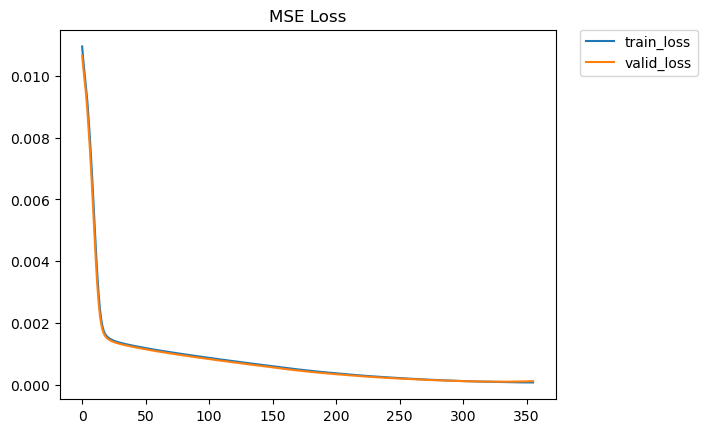

In [13]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [14]:
inputs = valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)

len(inputs)

17

In [15]:
model.eval()
prediction = []
batch_size = 3
iterations =  int(inputs.shape[0]/3)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0].detach().numpy())
    prediction.append(preds[1].detach().numpy())
    prediction.append(preds[2].detach().numpy())
prediction = np.array(prediction)

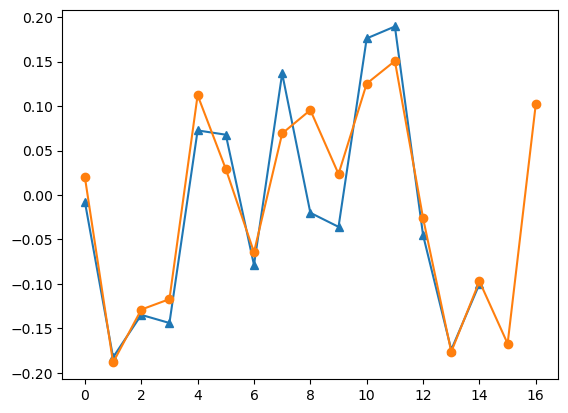

In [16]:
plt.plot(prediction, marker='^')
plt.plot(valid_y, marker='o')
plt.show()

In [17]:
error = 0

for i in range(len(prediction)):
    error = error + (prediction[i] - valid_y[i])**2
error/len(prediction)

array([0.00204942], dtype=float32)